# Group 14 - Project FP01
## Time series anomaly detection - RNN-EBM

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *
from models_functions import *

# Set style for matplotlib
plt.style.use("Solarize_Light2")

import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#### Various parameters

In [3]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

file_name_normal = "_20220811_rbtc_"
file_name_collisions = "_collision_20220811_rbtc_"

recording_normal = [0, 2, 3, 4]
recording_collisions = [1, 5]

freq_str = freq.replace(".", "_")
features_folder_normal = f"./features/normal{freq_str}/"
features_folder_collisions = f"./features/collisions{freq_str}/"

### Data

In [4]:
df_features_normal, df_normal_raw, _ = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, None)
df_features_collisions, df_collisions_raw, df_collisions_raw_action = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, None)
df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, None)
df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, None)

Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
--- 131.58519840240479 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 47.715678215026855 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


--- 23.966639757156372 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 27.29919743537903 seconds ---


In [5]:
# df_features_normal, df_normal_raw, _ = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, f"{features_folder_normal}")
# df_features_collisions, df_collisions_raw, df_collisions_raw_action = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, f"{features_folder_collisions}1_5/")
# df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, f"{features_folder_collisions}1/")
# df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, f"{features_folder_collisions}5/")

In [6]:
X_train, y_train, X_test, y_test, df_test = get_train_test_data(df_features_normal, df_features_collisions, full_normal=True)
X_train_1, y_train_1, X_test_1, y_test_1, df_test_1 = get_train_test_data(df_features_normal, df_features_collisions_1, full_normal=True)
X_train_5, y_train_5, X_test_5, y_test_5, df_test_5 = get_train_test_data(df_features_normal, df_features_collisions_5, full_normal=True)

### Collisions

In [7]:
collisions_rec1, collisions_init1 = get_collisions('1', ROOTDIR_DATASET_ANOMALY)
collisions_rec5, collisions_init5 = get_collisions('5', ROOTDIR_DATASET_ANOMALY)

# Merge the collisions of the two recordings in one dataframe
collisions_rec = pd.concat([collisions_rec1, collisions_rec5])
collisions_init = pd.concat([collisions_init1, collisions_init5])

In [8]:
collisions_zones, y_collisions = get_collisions_zones_and_labels(collisions_rec, collisions_init, df_features_collisions)
collisions_zones_1, y_collisions_1 = get_collisions_zones_and_labels(collisions_rec1, collisions_init1, df_features_collisions_1)
collisions_zones_5, y_collisions_5 = get_collisions_zones_and_labels(collisions_rec5, collisions_init5, df_features_collisions_5)

## RNN-EBM for Anomaly Detection in Time Series Data

In [9]:
from algorithms.rnn_ebm import RecurrentEBM

# Disable eager execution
tf.compat.v1.disable_eager_execution()

classifier = RecurrentEBM(
    num_epochs=100,
    n_hidden=64,
    n_hidden_recurrent=32,
    min_lr=1e-4,
    min_energy=None,  # We'll set this to None initially and determine it after training
    batch_size=128,
    seed=42,
    gpu=None  # Set to None for CPU, or specify GPU index if available
)
# Train the RNN on normal data
classifier.fit(X_train)
print("RNN-EBM training completed.")


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]

RNN-EBM training completed.


### Predictions

Anomaly prediction completed.
Number of anomalies detected: 14 with threshold 588.3233795166016, std
Number of anomalies detected: 106 with threshold 121.0477523803711, mad
Number of anomalies detected: 16 with threshold 513.2418975830078, percentile
Number of anomalies detected: 14 with threshold 582.5549068450928, IQR
Number of anomalies detected: 306 with threshold 0.0, zero

choosen threshold type: mad, with value: 121.0478
F1 Score: 0.8531
Accuracy: 0.8987
Precision: 0.8491
Recall: 0.8571
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       201
           1       0.85      0.86      0.85       105

    accuracy                           0.90       306
   macro avg       0.89      0.89      0.89       306
weighted avg       0.90      0.90      0.90       306

ROC AUC Score: 0.9369


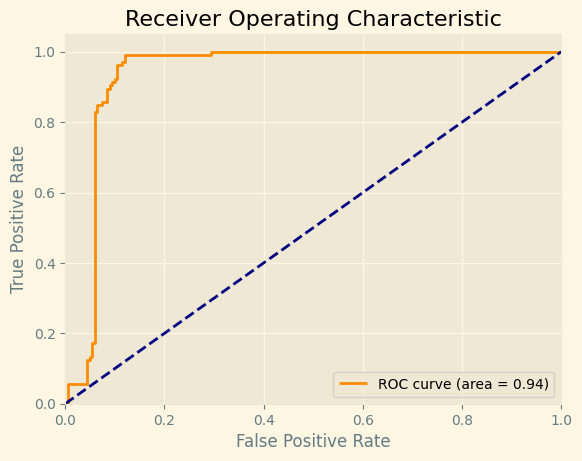

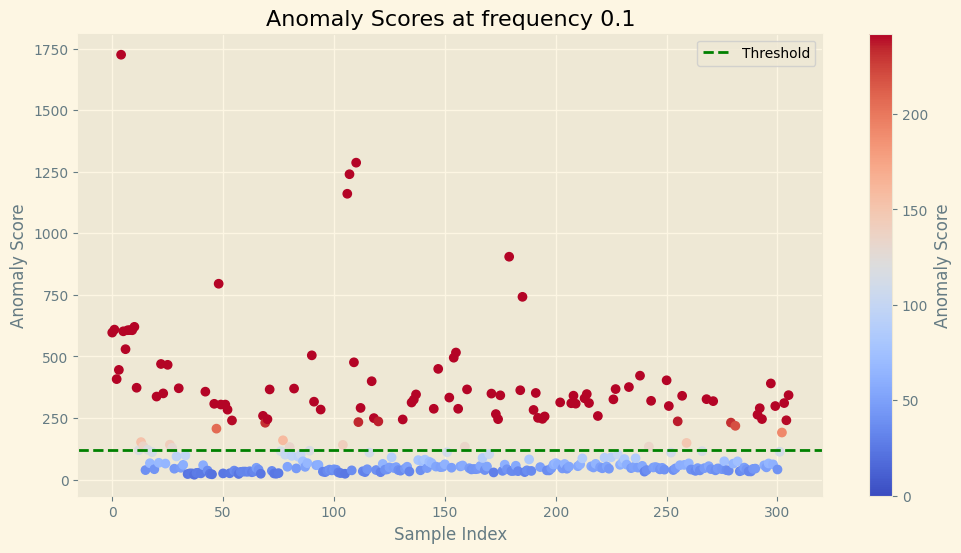

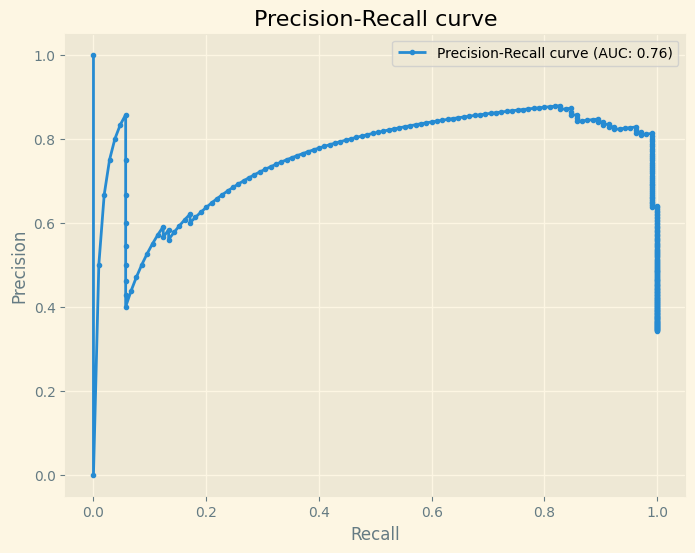

Anomalies detected: 106
Best threshold: 86.9414 | F1 Score: 0.8927 | Precision: 0.8125 | Recall: 0.9905
Anomalies detected with best threshold: 128

	-------------------------------------------------------------------------------------

Anomaly prediction completed.
Number of anomalies detected: 8 with threshold 444.2440719604492, std
Number of anomalies detected: 45 with threshold 83.85696411132812, mad
Number of anomalies detected: 9 with threshold 401.943095397949, percentile
Number of anomalies detected: 17 with threshold 165.6053009033203, IQR
Number of anomalies detected: 164 with threshold 0.0, zero

choosen threshold type: mad, with value: 83.8570
F1 Score: 0.8500
Accuracy: 0.9268
Precision: 0.7556
Recall: 0.9714
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       129
           1       0.76      0.97      0.85        35

    accuracy                           0.93       164
   macro avg       0.87      0.94      0.90       1

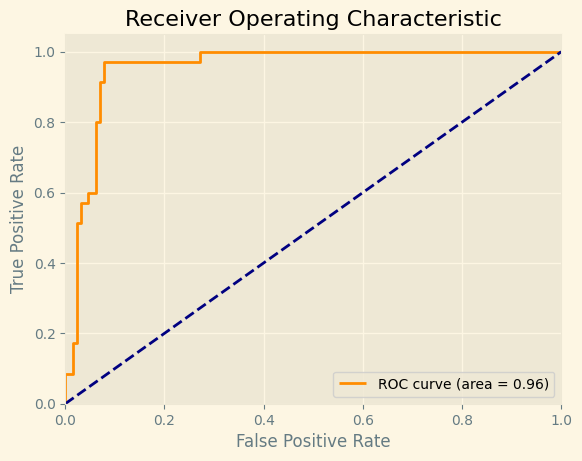

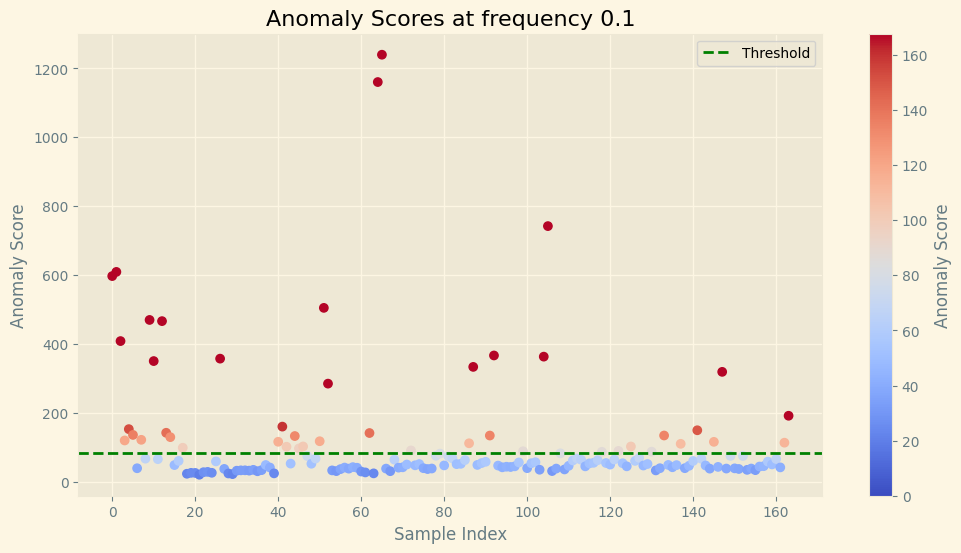

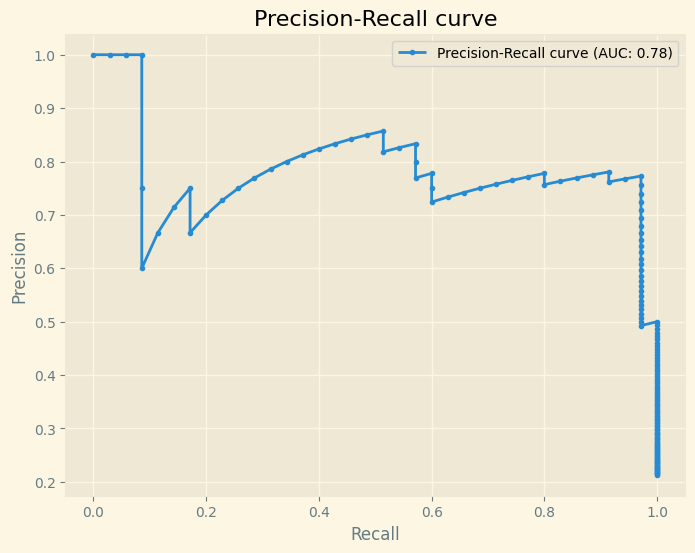

Anomalies detected: 45
Best threshold: 86.9414 | F1 Score: 0.8608 | Precision: 0.7727 | Recall: 0.9714
Anomalies detected with best threshold: 44

	-------------------------------------------------------------------------------------

Anomaly prediction completed.
Number of anomalies detected: 3 with threshold 631.3232574462891, std
Number of anomalies detected: 10 with threshold 580.61669921875, mad
Number of anomalies detected: 8 with threshold 603.470703125, percentile
Number of anomalies detected: 3 with threshold 745.6781139373779, IQR
Number of anomalies detected: 141 with threshold 0.0, zero

choosen threshold type: mad, with value: 580.6167
F1 Score: 0.0606
Accuracy: 0.5603
Precision: 0.2000
Recall: 0.0357
              precision    recall  f1-score   support

           0       0.59      0.91      0.71        85
           1       0.20      0.04      0.06        56

    accuracy                           0.56       141
   macro avg       0.39      0.47      0.39       141
weig

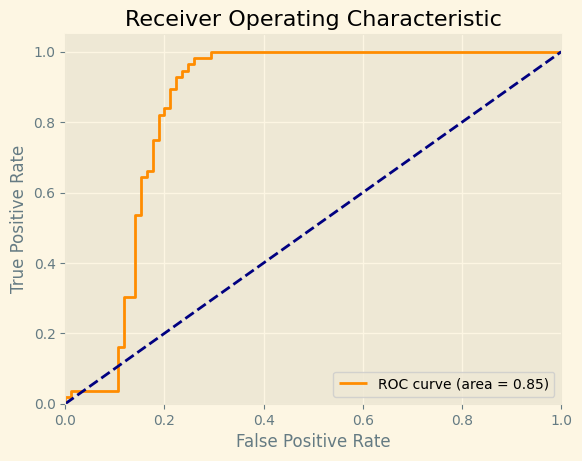

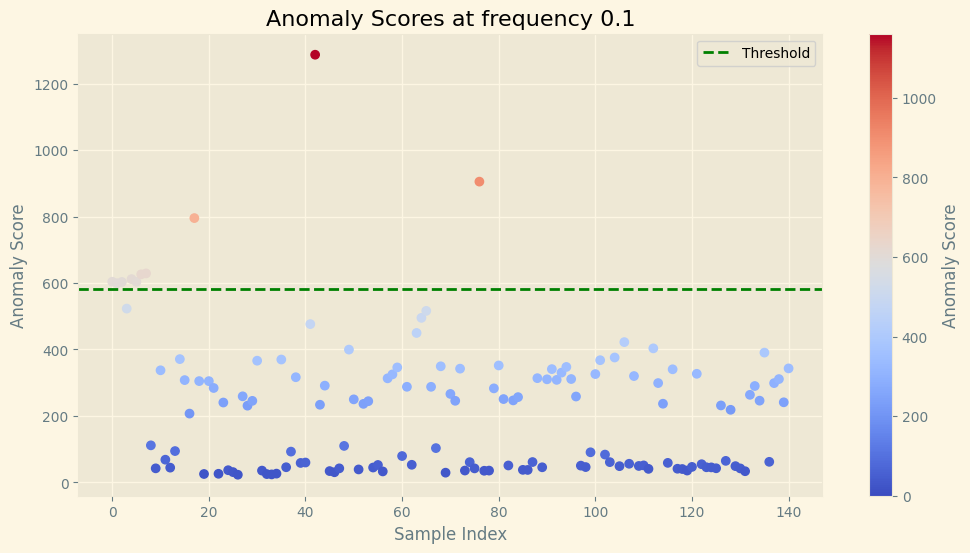

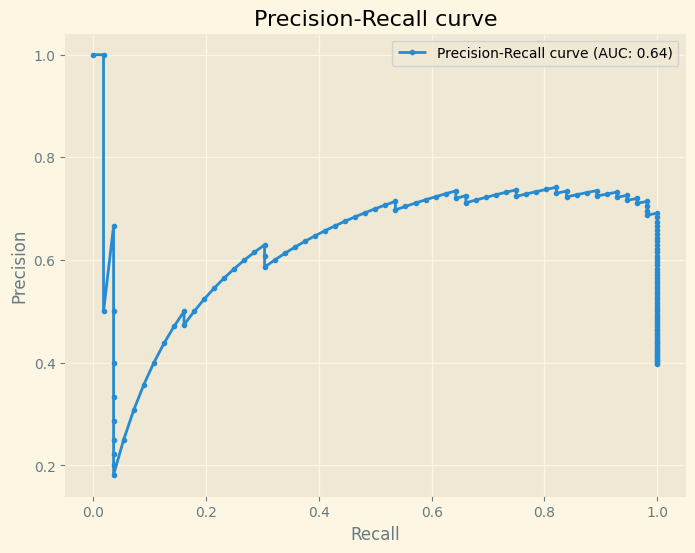

Anomalies detected: 10
Best threshold: 207.0646 | F1 Score: 0.8271 | Precision: 0.7143 | Recall: 0.9821
Anomalies detected with best threshold: 77

	-------------------------------------------------------------------------------------



In [10]:
df_test = get_statistics(X_test, y_collisions, classifier, df_test, freq, threshold_type="mad")
df_test_1 = get_statistics(X_test_1, y_collisions_1, classifier, df_test_1, freq, threshold_type="mad")
df_test_5 = get_statistics(X_test_5, y_collisions_5, classifier, df_test_5, freq, threshold_type="mad")

In [11]:
plot_anomalies_true_and_predicted(df_collisions_raw, df_collisions_raw_action, collisions_zones, df_test, title="Collisions zones vs predicted zones for both recordings")

In [12]:
plot_anomalies_true_and_predicted(df_collisions_raw_1, df_collisions_raw_action_1, collisions_zones_1, df_test_1, title="Collisions zones vs predicted zones for recording 1")

In [13]:
plot_anomalies_true_and_predicted(df_collisions_raw_5, df_collisions_raw_action_5, collisions_zones_5, df_test_5, title="Collisions zones vs predicted zones for recording 5")